During class we discussed a basic idea of nearest neighbours: each step simply introduce the nearest neighbour as the next node in the path. I had an idea for an addition to the method that I'm curious to see if they'll make a difference at all

Starting with the code from lecture

In [105]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from itertools import permutations

def cost_matrix(V):
    n = V.shape[0]
    C = np.zeros((n,n))
    for i in range(1,n):
        for j in range(0,i):
            C[i,j] = la.norm(V[i,:] - V[j,:])
            C[j,i] = C[i,j]
    return C

def tour_cost(C,tour):
    n = len(tour)
    cost = 0
    for i in range(n-1):
        cost += C[tour[i],tour[i+1]]
    cost += C[tour[-1],tour[0]]
    return cost

def brute_force(V):
    n = V.shape[0]
    tours = permutations(range(n))
    C = cost_matrix(V)
    optimal_cost = None
    for tour in tours:
        cost = tour_cost(C,tour)
        if optimal_cost is None or cost < optimal_cost:
            optimal_cost = cost
            optimal_tour = np.array(tour)
    return optimal_tour,optimal_cost

def plot_tour(V,tour, color='b', annotate=False):
    n = len(tour)
    for i in range(n-1):
        plt.plot([V[tour[i],0],V[tour[i+1],0]],[V[tour[i],1],V[tour[i+1],1]],color)
    plt.plot([V[tour[-1],0],V[tour[0],0]],[V[tour[-1],1],V[tour[0],1]],color)
    plt.scatter(V[:,0],V[:,1],s=10)

    if annotate:
        for i in range(n):
            x,y = V[tour[i]]
            plt.text(x, y + 0.05, f"tour #{i}")
        for i, (x,y) in enumerate(V):
            plt.text(x,y, f"node #{i}")

    plt.show()

def random_tour(n):
    return np.random.rand(n,2)

def nearest_neighbor(V,start=0,debug=False):
    n = V.shape[0]
    C = cost_matrix(V)
    tour = [start]
    nodes = list(range(n))
    nodes.remove(start)
    for i in range(1,n):
        next_i = np.argmin(C[tour[-1],nodes])
        next_node = nodes[next_i]
        if debug:
            print("costs going from ", tour[-1], " are ", C[tour[-1],nodes])
            print("next node =", next_node)
        tour.append(next_node)
        nodes.pop(next_i)
        
    cost = tour_cost(C,tour)
    return tour,cost

9.11407367764983


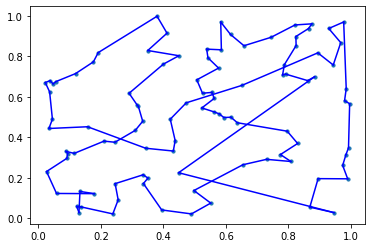

In [71]:
V = random_tour(100) 
tour,cost = nearest_neighbor(V,start=11)
print(cost)
plot_tour(V,tour)

In this example with many nodes we see one of the major flaws of nearest neighbours, that it only has local reasoning. It fails to consider how it's choice might affect choices later down in the path, resulting in some very inefficient pathing (for example that massive diagonal line running down the center). To fix this we would have to consider the node we're going to move to _after_ the nearest neighbour in some way.

My idea for how we could fix this is to employ a similar idea to chess algorithms.

In chess there's the idea of a minimax algorithm, one where the best move is not the one that results in the best position, but one where the opponent's best move after that move results in the best possible position. The algorithm doesn't just greedily choose the best move since it knows that it'll have to play more moves later on, so it chooses the move that will place it in the best position for the next move, and so on. Minimax algorithms have been found to be very effective for tree search problems such as chess, and my idea is that choosing which node to move to next is essentially the same tree search problem, so this algorithm should work here as well.

To adapt this idea to the nearest neighbours problems we can change our greedy strategy to not just take the closest neighbour, but rather the pair of neighbours with the shortest total distance for that pair, choosing the node that will eventually result in the lowest distance to coer two nodes, not just the closest node to our current position. 

The plan to implement this is to perform a lookahead to all possible choices of depth $n$ we can make from the current tour, build a tree out of those possible choices, and then picking the leaf of the tree with the smallest possible total distance.

In [72]:
# def lookahead_nearest_neighbor(V,start=0, lookahead=1,closest=True):
#     n = V.shape[0]
#     C = cost_matrix(V)

#     # we build a full tour by recursively picking the next location we want to visit via the lookahead strategy
#     def build_tour(current_tour, available_nodes):
#         if len(available_nodes) == 1:
#             return current_tour + [available_nodes[0]]
#         else:
#             next_tour, new_avail = lookahead_pick(current_tour, available_nodes)
#             return build_tour(next_tour, new_avail)

#     # we pick the next location by building a list of possible choices, sorting to chose the lowest one, and choosing that
#     def lookahead_pick(current_tour, available_nodes):
#         peek = min(len(available_nodes), lookahead)
#         choices = lookahead_get_choices(current_tour, available_nodes, peek)
#         # print("current", current_tour)
#         # print("choices", choices)
#         sorted_choices = sorted(choices, key=lambda x: x[0])
#         if closest:
#             best = sorted_choices[0]
#             return best[1][0], best[1][1]
#         else:
#             best = sorted_choices[-1]
#             return best[1][0], best[1][1]
        
#     # to get the list of possible choices with a given amount of lookahead, we again use a recursive function
#     def lookahead_get_choices(current_tour, available_nodes, peek):
#         if peek == 0:
#             t = pick_next_tour_location(current_tour, available_nodes)
#             return [[tour_cost(C, t[0]), t]]
#         else:
#             choices = []
#             for node_i, node in enumerate(available_nodes):
#                 temp = list(available_nodes)
#                 temp.pop(node_i)
#                 choices += lookahead_get_choices(current_tour + [node], temp, peek-1)
#             return choices

#     # wait huh why does it do this...?
#     def pick_next_tour_location(current_tour, available_nodes):
#         if len(available_nodes) == 0:
#             return (current_tour, [])
#         next_i = np.argmin(C[current_tour[-1],available_nodes])
#         next_node = available_nodes[next_i]
#         temp = list(available_nodes)
#         temp.pop(next_i)
#         return (current_tour + [next_node], temp)

#     tour = [start]
#     nodes = list(range(n))
#     nodes.remove(start)
#     tour = build_tour(tour, nodes)
#     cost = tour_cost(C,tour)
#     return tour,cost

In [102]:
import itertools
def lookahead_nearest_neighbor(V,start=0, lookahead=1,debug=False):
    n = V.shape[0]
    C = cost_matrix(V)
    all_nodes = list(range(n))

    # mostly the same as tour_cost, but for incomplete tours so the cost to return to the start is not considered
    def choice_cost(nodes):
        n = len(nodes)
        cost = 0
        for i in range(n-1):
            cost += C[nodes[i],nodes[i+1]]
        return cost

    # we pick the next location by building a list of possible choices, sorting to chose the lowest one, and choosing that
    def lookahead_pick(current_tour):
        available_nodes = list(all_nodes)
        for node in tour:
            available_nodes.remove(node)
            
        peek = min(len(available_nodes), lookahead + 1)
        choices = [list(xs) for xs in itertools.permutations(available_nodes, peek)]
        # build a list of the choice of next lookahead # of locations, the resulting tour, and the cost of those choices
        tours_and_costs = [(choice_cost([current_tour[-1]] + next_steps), current_tour + next_steps, next_steps) for next_steps in choices]
        sorted_choices = sorted(tours_and_costs, key=lambda x: x[0])
        # print("sorted choices", sorted_choices)
        best = sorted_choices[0]
        best_cost, best_next_tour, best_next_choices = best
        if debug:
            print("sorted choices for the next choices")
            for x in sorted_choices:
                print(x)
            print(f"current tour = {current_tour} | best next choices = {best_next_choices}")
        
        # if we return all of the best_next_choices, then we essentially pick 3 locations at once
        # if we only return the first choice in the best_next_choices list, then we allow the algorithm to pivot later on
        # compare how these two strategies differ
        return [best_next_choices[0]]
        # return best_next_choices

    tour = [start]
    while len(tour) < n:
        tour = tour + lookahead_pick(tour)
    cost = tour_cost(C,tour)
    return tour,cost

First let's sanity check that the code works

3.4577112664527547


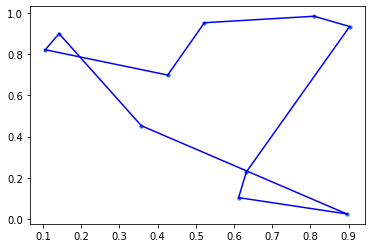

In [74]:
V = random_tour(10) 
lookahead_tour, lookahead_cost = lookahead_nearest_neighbor(V,start=0, lookahead=1)
print(lookahead_cost)
plot_tour(V, lookahead_tour)

With zero lookahead, the algorithm should just pick the nearest neighbour, meaning it should have an identical result to the original nearest neighbour algorithm

9.04560438858263


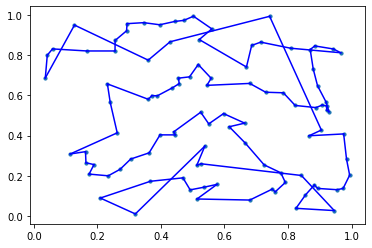

9.04560438858263


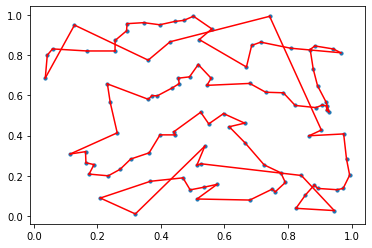

In [75]:
# zero lookahead, should be identical
V = random_tour(100) 
lookahead_tour, lookahead_cost = lookahead_nearest_neighbor(V,start=0, lookahead=0)
print(lookahead_cost)
plot_tour(V, lookahead_tour)

normal_tour, normal_cost = nearest_neighbor(V,start=0)
print(normal_cost)
plot_tour(V, normal_tour, color='r')


What happens if we allow the new greedy algorithm to look ahead by one step?

11.275342548831691


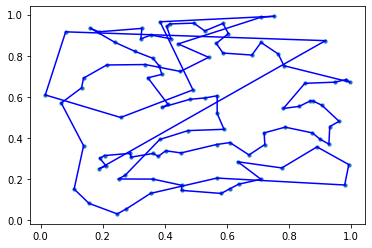

9.13332094896833


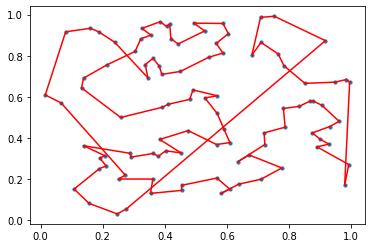

In [76]:
# one lookahead
V = random_tour(100) 
lookahead_tour, lookahead_cost = lookahead_nearest_neighbor(V,start=0, lookahead=1)
print(lookahead_cost)
plot_tour(V, lookahead_tour)

normal_tour, normal_cost = nearest_neighbor(V,start=0)
print(normal_cost)
plot_tour(V, normal_tour, color='r')

We see that the lookahead algorithm in blue gets a... worse result.

Why? Does this also happen with higher lookaheads?

8.326099726945037


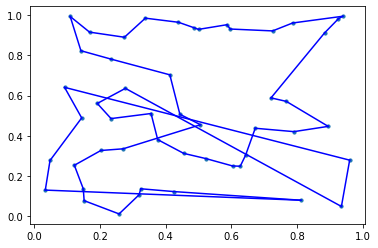

6.44684591271841


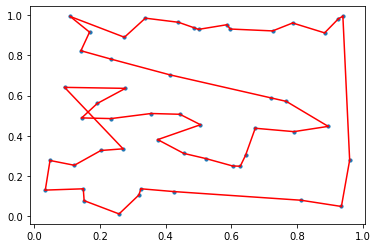

In [77]:
# 2 lookahead
V = random_tour(50) 
lookahead_tour, lookahead_cost = lookahead_nearest_neighbor(V,start=0, lookahead=2)
print(lookahead_cost)
plot_tour(V, lookahead_tour)

normal_tour, normal_cost = nearest_neighbor(V,start=0)
print(normal_cost)
plot_tour(V, normal_tour, color='r')

5.174004800006347


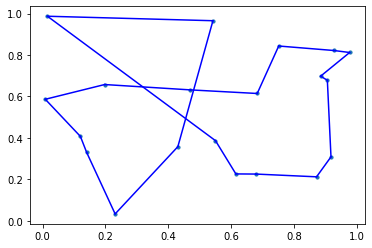

5.139982415985478


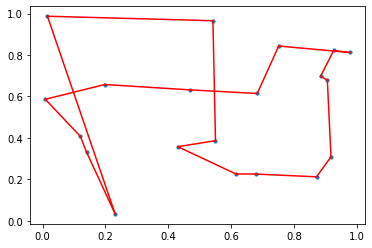

In [82]:
# 3 lookahead
V = random_tour(20) 
lookahead_tour, lookahead_cost = lookahead_nearest_neighbor(V,start=0, lookahead=3)
print(lookahead_cost)
plot_tour(V, lookahead_tour)

normal_tour, normal_cost = nearest_neighbor(V,start=0)
print(normal_cost)
plot_tour(V, normal_tour, color='r')

It does! It appears that in all cases this lookahead algorithm performs worse than simply nearest neighbours, but why?


Can I build a minimal example which shows why this lookahead strategy performs better?

found a tour where lookahead does better
sorted choices for the next choices
(0.8556264341104394, [0, 4, 3], [4, 3])
(0.9295227061225062, [0, 3, 4], [3, 4])
(0.9608247595075103, [0, 2, 4], [2, 4])
(1.0710781385706665, [0, 2, 3], [2, 3])
(1.123396436778428, [0, 4, 2], [4, 2])
(1.2703377931720161, [0, 3, 1], [3, 1])
(1.2776277614761626, [0, 4, 1], [4, 1])
(1.307546087853651, [0, 3, 2], [3, 2])
(1.4453104227328155, [0, 2, 1], [2, 1])
(1.7212070042646044, [0, 1, 3], [1, 3])
(1.8023932445808177, [0, 1, 4], [1, 4])
(2.132647583108388, [0, 1, 2], [1, 2])
current tour = [0] | best next choices = [4, 3]
sorted choices for the next choices
(0.5613293510820221, [0, 4, 3, 1], [3, 1])
(0.598537645763657, [0, 4, 3, 2], [3, 2])
(0.8663076484316454, [0, 4, 2, 3], [2, 3])
(0.9833306784477454, [0, 4, 1, 3], [1, 3])
(1.2405399325937945, [0, 4, 2, 1], [2, 1])
(1.3947712572915292, [0, 4, 1, 2], [1, 2])
current tour = [0, 4] | best next choices = [3, 1]
sorted choices for the next choices
(1.313585016975315

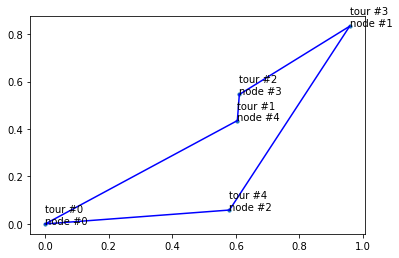

costs going from  0  are  [1.27013479 0.58279762 0.81926557 0.7453693 ]
next node = 2
costs going from  2  are  [0.8625128  0.48828051 0.37802713]
next node = 4
costs going from  4  are  [0.53225846 0.11025713]
next node = 3
costs going from  3  are  [0.45107222]
next node = 1
2.792288895788371
[0, 2, 4, 3, 1]


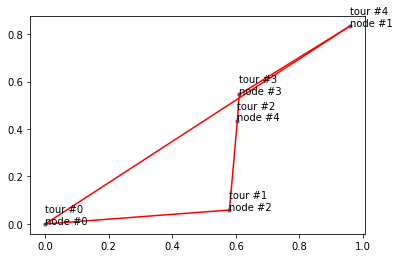

In [106]:

lookahead_better = False
while not lookahead_better:
    # one lookahead
    V = random_tour(5) 
    # force the starting position to be at the origin
    V[0] = (0,0)
    lookahead_tour, lookahead_cost = lookahead_nearest_neighbor(V,start=0, lookahead=1, debug=False)
    normal_tour, normal_cost = nearest_neighbor(V,start=0,debug=False)
    lookahead_better = normal_cost > lookahead_cost

print("found a tour where lookahead does better")
lookahead_tour, lookahead_cost = lookahead_nearest_neighbor(V,start=0, lookahead=1, debug=True)
print(lookahead_cost)
print(lookahead_tour)
plot_tour(V, lookahead_tour, annotate=True)
normal_tour, normal_cost = nearest_neighbor(V,start=0,debug=True)
print(normal_cost)
print(normal_tour)
plot_tour(V, normal_tour, color='r', annotate=True)

Huh ok so here we have an case where the alternative strategy does better, why doesn't this always happen?

Let's try to find some small examples where the lookahead strategy does worse

found a tour where lookahead does worse
sorted choices for the next choices
(0.8703825893316431, [0, 3, 4], [3, 4])
(0.8962300313215343, [0, 4, 3], [4, 3])
(0.8995289456679223, [0, 1, 2], [1, 2])
(1.2742917089522923, [0, 1, 4], [1, 4])
(1.283361745153456, [0, 2, 1], [2, 1])
(1.3079163873626944, [0, 1, 3], [1, 3])
(1.5899055153806192, [0, 4, 1], [4, 1])
(1.5955491453542314, [0, 4, 2], [4, 2])
(1.5976827518011303, [0, 3, 1], [3, 1])
(1.6444178700699148, [0, 3, 2], [3, 2])
(1.663768138411438, [0, 2, 4], [2, 4])
(1.7384843051170127, [0, 2, 3], [2, 3])
current tour = [0] | best next choices = [3, 4]
sorted choices for the next choices
(0.8906742529565308, [0, 3, 4, 1], [4, 1])
(0.896317882930143, [0, 3, 4, 2], [4, 2])
(1.243211652141648, [0, 3, 1, 2], [1, 2])
(1.2899467704104326, [0, 3, 2, 1], [2, 1])
(1.6179744154260178, [0, 3, 1, 4], [1, 4])
(1.6703531636684148, [0, 3, 2, 4], [2, 4])
current tour = [0, 3] | best next choices = [4, 1]
sorted choices for the next choices
(1.2095869737312457

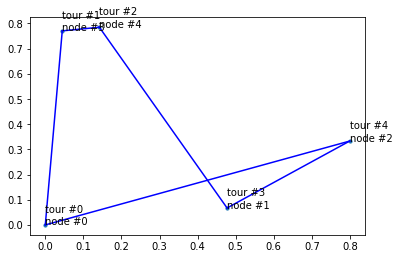

costs going from  0  are  [0.48211684 0.86594964 0.7718832  0.79773065]
next node = 1
costs going from  1  are  [0.41741211 0.82579955 0.79217487]
next node = 2
costs going from  2  are  [0.87253467 0.7978185 ]
next node = 4
costs going from  4  are  [0.09849938]
next node = 3
2.5677300334809856
[0, 1, 2, 4, 3]


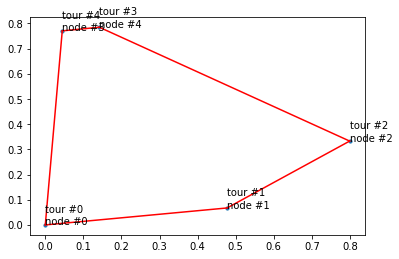

In [107]:

lookahead_worse = False
while not lookahead_worse:
    # one lookahead
    V = random_tour(5) 
    # force the starting position to be at the origin
    V[0] = (0,0)
    lookahead_tour, lookahead_cost = lookahead_nearest_neighbor(V,start=0, lookahead=1, debug=False)
    normal_tour, normal_cost = nearest_neighbor(V,start=0,debug=False)
    lookahead_worse = normal_cost < lookahead_cost

print("found a tour where lookahead does worse")
lookahead_tour, lookahead_cost = lookahead_nearest_neighbor(V,start=0, lookahead=1, debug=True)
print(lookahead_cost)
print(lookahead_tour)
plot_tour(V, lookahead_tour, annotate=True)
normal_tour, normal_cost = nearest_neighbor(V,start=0,debug=True)
print(normal_cost)
print(normal_tour)
plot_tour(V, normal_tour, color='r', annotate=True)

What's happening in this example?

The lookahead tour goes to node 3 first because it sees that nodes 3 and 4 are next to each other and have the lowest total distance for two nodes. This is correct.

After going to node 3 it takes node 4 next as expected.

After node 4 it decides between going to 1 then 2 then 0 or 2 then 1 then 0 and it decides on the prior. Why? Well because when starting from 4 it sees that 1 is closer than 2 so it goes there first. So it goes 1 then 2 then 0, which is longer. How can we fix this?

A combination of a longer lookahead and one that considers returning to the origin would fix this, but it seems like there's a more fundamental problem than the one we see in this example so let's keep looking, but with more nodes and more lookahead

found a tour where lookahead does worse
3.964413630738736
[0, 6, 1, 3, 7, 2, 5, 4]


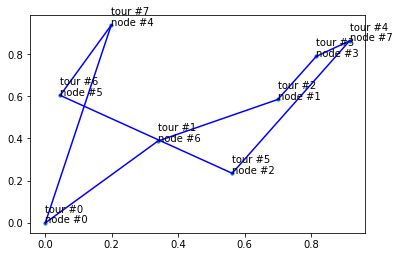

3.21425360020073
[0, 6, 2, 1, 3, 7, 4, 5]


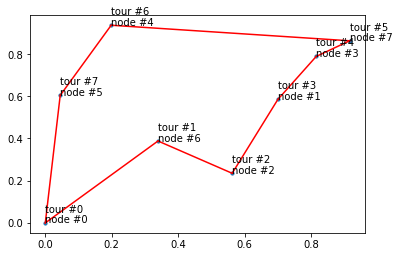

In [110]:

lookahead_worse = False
while not lookahead_worse:
    # one lookahead
    V = random_tour(8) 
    # force the starting position to be at the origin
    V[0] = (0,0)
    lookahead_tour, lookahead_cost = lookahead_nearest_neighbor(V,start=0, lookahead=2, debug=False)
    normal_tour, normal_cost = nearest_neighbor(V,start=0,debug=False)
    lookahead_worse = normal_cost < lookahead_cost

print("found a tour where lookahead does worse")
print(lookahead_cost)
print(lookahead_tour)
plot_tour(V, lookahead_tour, annotate=True)
print(normal_cost)
print(normal_tour)
plot_tour(V, normal_tour, color='r', annotate=True)

From this we can make a hypothesis for what's causing the lookahead strategy to do worse, it attempts to go straight for the areas of clumped together nodes (nodes 1,3,7 in the above example). After touring through those nearby nodes it then has to jump out farther to reach the next group of nearby nodes.

Nearest neighbours performs better because it never makes a big jump to go towards a group of nearby nodes, while still always routing over the same groups of nearby nodes.

This matches what we saw in some of the examples earlier with many nodes, it appeared that there were many long lines crisscrosssing the map in the lookahead greedy scheme. This was probably the same pattern of jumping towards an area of clumped nodes and then having to jump to the next one, instead of taking each group as it appears like the nearest neighbours algorithm

From this hypothesis we can try to build an example that the lookahead method completely fails at. The idea is to have a series of clumps around in a convex shape. The nearest neighbours algorithm should just follow around the convex shell but the lookahead algorithm will jump across the center to try to reach the other clump of nodes 

3.638098640466703
[0, 3, 1, 4, 2, 8, 7, 5, 6, 9]


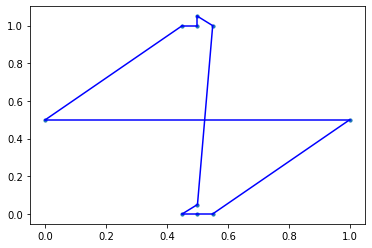

3.1027684006642913
[0, 3, 1, 2, 4, 9, 6, 5, 7, 8]


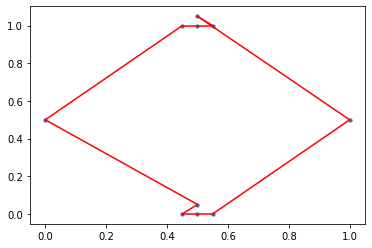

In [122]:
V = np.array([
    (0,0.5),
    (0.5,1),(0.55,1),(0.45,1),(0.5,1.05), # clump of nearby nodes
    (0.5,0),(0.55,0),(0.45,0),(0.5,0.05), # another clump
    (1,0.5) # opposite end
    ])
lookahead_tour, lookahead_cost = lookahead_nearest_neighbor(V,start=0, lookahead=2, debug=False)
normal_tour, normal_cost = nearest_neighbor(V,start=0,debug=False)
print(lookahead_cost)
print(lookahead_tour)
plot_tour(V, lookahead_tour, annotate=False)
print(normal_cost)
print(normal_tour)
plot_tour(V, normal_tour, color='r', annotate=False)

What about a more extreme example?

41.22048365122893
[0, 4, 2, 3, 7, 5, 25, 26, 24, 27, 28, 31, 29, 30, 10, 14, 12, 13, 35, 33, 34, 36, 39, 37, 38, 18, 22, 20, 21, 43, 41, 42, 40, 17, 19, 16, 15, 9, 11, 32, 8, 6, 23, 1]


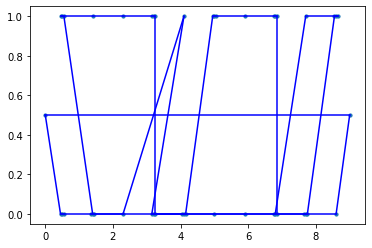

18.94600260923735
[0, 4, 2, 3, 7, 5, 6, 8, 11, 9, 10, 14, 12, 13, 15, 16, 19, 17, 18, 22, 20, 21, 23, 1, 42, 41, 43, 40, 38, 37, 39, 36, 34, 33, 35, 32, 30, 29, 31, 28, 27, 25, 24, 26]


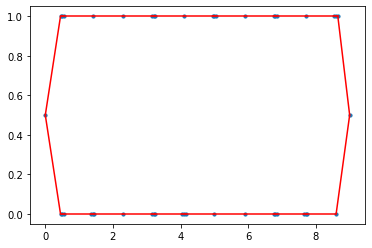

In [121]:
import random
row_len = 10

V = [(0,0.5), (0.9*row_len,0.5)]
for y in [0,1]:
    for group in range(row_len):
        x = 0.9*group + 0.5
        if random.randint(0,1) == 1:
            # clump
            V.append((x, y))
            V.append((x+0.05, y))
            V.append((x-0.05, y))
        else:
            # individual node
            V.append((x,y))
V = np.array(V)
lookahead_tour, lookahead_cost = lookahead_nearest_neighbor(V,start=0, lookahead=2, debug=False)
normal_tour, normal_cost = nearest_neighbor(V,start=0,debug=False)
print(lookahead_cost)
print(lookahead_tour)
plot_tour(V, lookahead_tour, annotate=False)
print(normal_cost)
print(normal_tour)
plot_tour(V, normal_tour, color='r', annotate=False)

# Conclusion

So we looked at a potential alternative to greedy nearby neighbours, and we found that the method totally doesn't work! Nearest neighbours may sound very simple but in it's simplicity it actually captures a number of interesting factors of the TS problem, and in the process of trying to make it "smarter" I ended up breaking some of those properties.